## Плугатирьов Дмитро ІП-15

# Комп'ютерний практикум №1

## Залежності

In [1513]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Налаштування виводу на екран

In [1514]:
def plot_histogram(values: np.ndarray, bins: int, title: str, color: str = 'blue') -> plt.Axes:
    _, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(title)
    ax.set_xlabel('Значення')
    ax.set_ylabel('Частота')
    ax.grid(True)
    ax.hist(values, bins=bins, color=color)
    return ax

def format_mean_std(mean_std: tuple, title):
    mean, std = mean_std
    return f'{title}: \nСереднє: {mean:.3f}, Std: {std:.3f}'

def format_chi2_info(chi2, chi2_k, title):
    return f'{title}: \nChi^2: {chi2:.3f}, Chi^2 k: {chi2_k}'

## Обчислення значень

In [1515]:
def get_sturges_bin_count(sample_size: int) -> int:
    """Розраховує оптимальну кількість інтервалів за правилом Стерджеса."""
    return math.ceil(math.log2(sample_size) + 1)

def get_bin_intervals(bin_edges : np.ndarray) -> list[tuple[float, float]]:
    """Перетворює масив меж [0, 5, 10] на пари [(0, 5), (5, 10)]."""
    return list(zip(bin_edges[:-1], bin_edges[1:]))

def calculate_sample_stats(data: np.ndarray) -> tuple[float, float]:
    """Повертає середнє (mean) та стандартне відхилення (std) вибірки."""
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    return (mean, std)

# Chi2 з таблиці (заздалегідь визначена) (функція відсоткової точки - ppf)
def get_chi2_critical_value(alpha: float, num_bins: int, num_params: int) -> float:
    """
    Повертає критичне значення з таблиці розподілу.
    df (degrees of freedom) = кількість інтервалів - кількість оцінених параметрів - 1
    """
    degrees_of_freedom = num_bins - num_params - 1
    return stats.chi2.ppf(1 - alpha, df=degrees_of_freedom)

def calculate_chi2_statistic(
    sample_size: int, 
    observed_counts: np.ndarray, 
    bin_edges: np.ndarray, 
    probability_func: callable, 
    *dist_params
    ) -> float:
    intervals = zip(bin_edges[:-1], bin_edges[1:])
    expected_probs = np.array([probability_func(l, r, *dist_params) for l, r in intervals])

    expected_counts = sample_size * expected_probs
    # Захист від ділення на 0 (хоча при рівноймовірних інтервалах це малоймовірно)
    expected_counts[expected_counts == 0] = 1e-10
    
    chi2 = np.sum(np.square(observed_counts - expected_counts) / expected_counts)
    return chi2

def is_hypothesis_accepted(chi2_stat: float, critical_value: float) -> bool:
    return chi2_stat <= critical_value

# Експоненційний закон розподілу

## Побудова графіку для перевірки закону


>>> ТЕСТУВАННЯ ДЛЯ LAMBDA = 0.5
Оцінене lambda: 0.4972 (Задане: 0.5)
Chi2 статистика: 6.6034
Критичне значення (df=10): 18.3070
Результат: Закон ПІДТВЕРДЖЕНО
Експоненціальний (λ=0.5): 
Середнє: 2.011, Std: 1.992

>>> ТЕСТУВАННЯ ДЛЯ LAMBDA = 1.0
Оцінене lambda: 1.0084 (Задане: 1.0)
Chi2 статистика: 6.2167
Критичне значення (df=8): 15.5073
Результат: Закон ПІДТВЕРДЖЕНО
Експоненціальний (λ=1.0): 
Середнє: 0.992, Std: 0.993

>>> ТЕСТУВАННЯ ДЛЯ LAMBDA = 2.5
Оцінене lambda: 2.5162 (Задане: 2.5)
Chi2 статистика: 13.1199
Критичне значення (df=11): 19.6751
Результат: Закон ПІДТВЕРДЖЕНО
Експоненціальний (λ=2.5): 
Середнє: 0.397, Std: 0.392

>>> ТЕСТУВАННЯ ДЛЯ LAMBDA = 5.0
Оцінене lambda: 4.9906 (Задане: 5.0)
Chi2 статистика: 12.8406
Критичне значення (df=11): 19.6751
Результат: Закон ПІДТВЕРДЖЕНО
Експоненціальний (λ=5.0): 
Середнє: 0.200, Std: 0.197


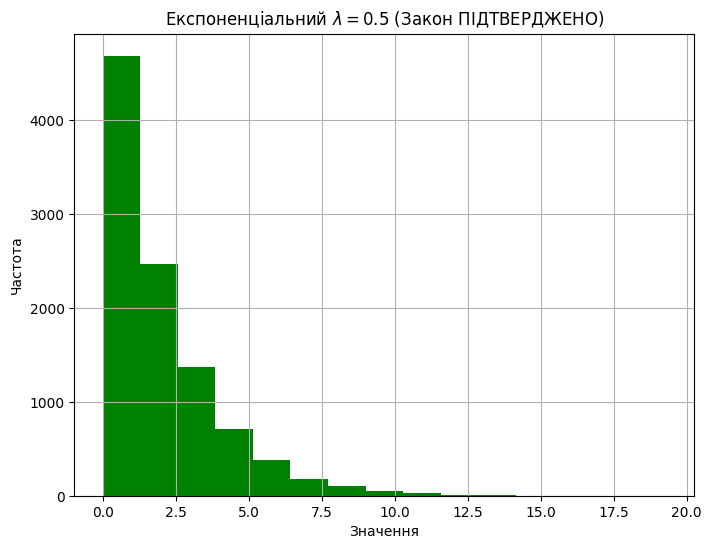

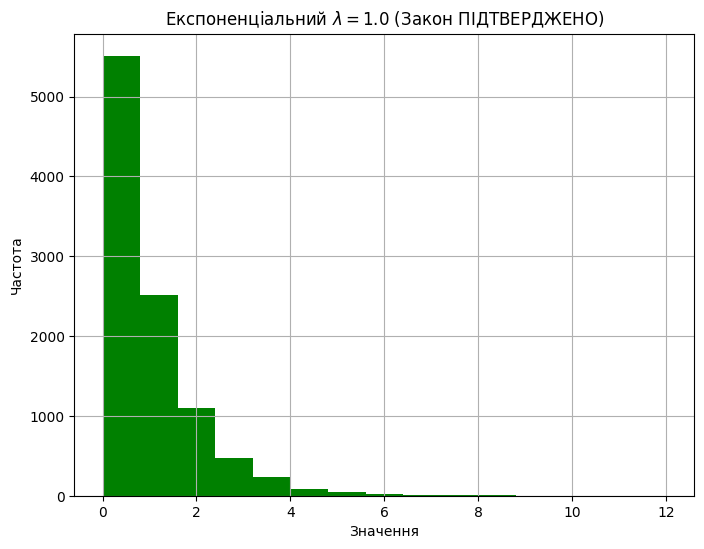

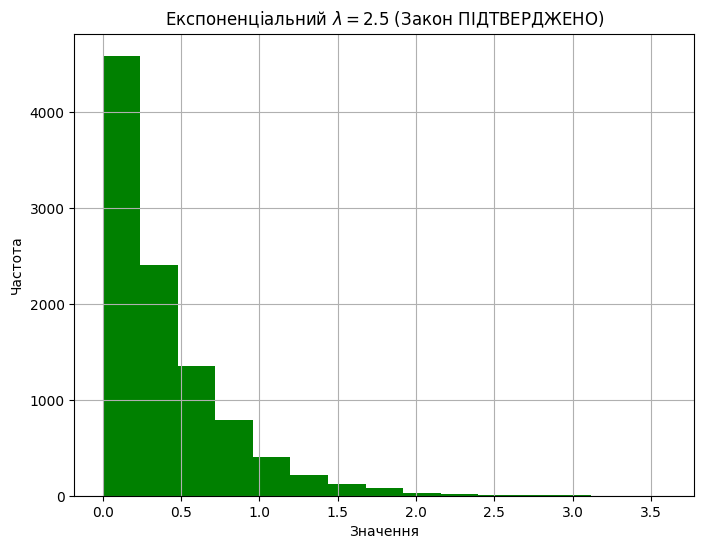

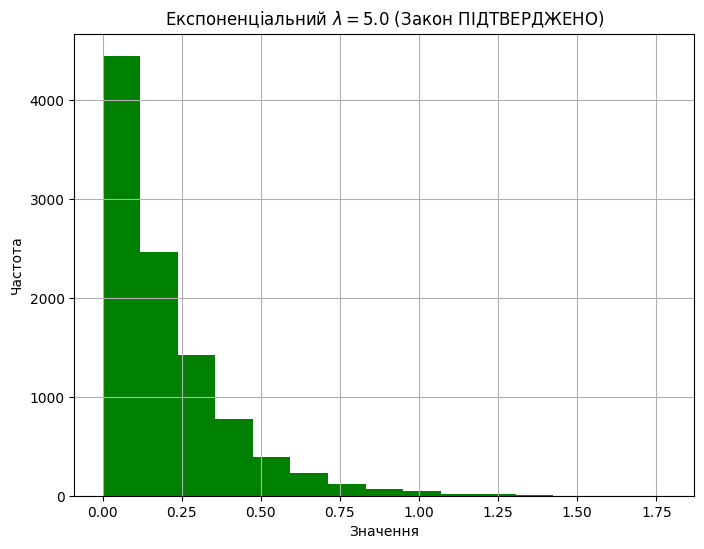

In [1516]:
import numpy as np
import matplotlib.pyplot as plt

# 1. ФУНКЦІЯ ПЕРЕВІРКИ (Об'єднує генерацію та тест)
def test_exponential_hypothesis(target_lambda, sample_size):
    print("\n" + "="*50)
    print(f">>> ТЕСТУВАННЯ ДЛЯ LAMBDA = {target_lambda}")
    print("="*50)

    # --- А. Генерація вибірки (Формула з завдання) ---
    uniform_samples = np.random.uniform(size=sample_size)
    exponential_samples = -1 / target_lambda * np.log(uniform_samples)

    # Розрахунок кількості бінів (правило Стерджеса або корінь)
    # Якщо у вас немає функції get_sturges_bin_count, розкоментуйте рядок нижче:
    # num_bins = int(np.log2(sample_size) + 1) 
    num_bins = get_sturges_bin_count(sample_size) 

    # --- Б. Отримання гістограми та оцінка параметрів ---
    observed_counts, bin_edges = np.histogram(exponential_samples, bins=num_bins)
    
    # Оцінюємо лямбда з вибірки (для чистоти експерименту)
    # Хоча ми знаємо target_lambda, тест Хі-квадрат зазвичай використовує оцінений параметр
    estimated_lambda = 1 / np.mean(exponential_samples)
    n_samples = len(exponential_samples)
    
    # --- В. Розрахунок теоретичних частот ---
    raw_expected = []
    for i in range(len(bin_edges) - 1):
        a = bin_edges[i]
        b = bin_edges[i+1]
        # P(a <= X < b) = exp(-lam*a) - exp(-lam*b)
        prob = np.exp(-estimated_lambda * a) - np.exp(-estimated_lambda * b)
        raw_expected.append(prob * n_samples)

    # --- Г. Об'єднання малих інтервалів (Ваш алгоритм) ---
    final_obs = []
    final_exp = []
    current_o = 0
    current_e = 0

    for o, e in zip(observed_counts, raw_expected):
        current_o += o
        current_e += e
        if current_e >= 5:
            final_obs.append(current_o)
            final_exp.append(current_e)
            current_o = 0
            current_e = 0
            
    if current_e > 0:
        if len(final_exp) > 0:
            final_obs[-1] += current_o
            final_exp[-1] += current_e
        else:
            final_obs.append(current_o)
            final_exp.append(current_e)

    final_obs = np.array(final_obs)
    final_exp = np.array(final_exp)

    # --- Д. Розрахунок статистики Хі-квадрат ---
    chi2_stat = np.sum((final_obs - final_exp)**2 / final_exp)
    df = len(final_obs) - 1 - 1 # (кількість груп - 1 - кількість параметрів)

    # --- Е. Критичне значення ---
    limit = stats.chi2.ppf(0.95, df)

    # --- Є. Вивід результатів ---
    print(f"Оцінене lambda: {estimated_lambda:.4f} (Задане: {target_lambda})")
    print(f"Chi2 статистика: {chi2_stat:.4f}")
    print(f"Критичне значення (df={df}): {limit:.4f}")
    
    result_msg = "Закон ПІДТВЕРДЖЕНО" if chi2_stat < limit else "Закон ВІДХИЛЕНО"
    print(f"Результат: {result_msg}")

    # Виклик ваших функцій для статистики (якщо вони визначені)
    try:
        estats = calculate_sample_stats(exponential_samples)
        print(format_mean_std(estats, f'Експоненціальний (λ={target_lambda})'))
    except NameError:
        pass # Ігноруємо, якщо функції не знайдено

    # --- Ж. Побудова графіка ---
    plot_title = f'Експоненціальний $\lambda={target_lambda}$ ({result_msg})'
    plot_histogram(
        exponential_samples, 
        num_bins, 
        title=plot_title, 
        color='green' if chi2_stat < limit else 'red'
    )

# ==========================================
# 2. ГОЛОВНИЙ ЦИКЛ (Виконання завдання)
# ==========================================

sample_size_global = 10000 
# Список різних лямбда для перевірки, як вимагає завдання
lambda_values_to_test = [0.5, 1.0, 2.5, 5.0]

for lam in lambda_values_to_test:
    test_exponential_hypothesis(target_lambda=lam, sample_size=sample_size_global)

# Нормальний закон розподілу


>>> ТЕСТУВАННЯ: a (Mean) = 0, sigma (Std) = 1
Оцінені параметри: Mean=-0.0024, Std=0.9981
Chi2 статистика: 10.8847
Критичне значення (df=12): 21.0261
Результат: Закон ПІДТВЕРДЖЕНО

>>> ТЕСТУВАННЯ: a (Mean) = -5, sigma (Std) = 4
Оцінені параметри: Mean=-4.9811, Std=4.0010
Chi2 статистика: 12.4765
Критичне значення (df=11): 19.6751
Результат: Закон ПІДТВЕРДЖЕНО

>>> ТЕСТУВАННЯ: a (Mean) = 10, sigma (Std) = 2
Оцінені параметри: Mean=9.9930, Std=2.0139
Chi2 статистика: 4.8752
Критичне значення (df=12): 21.0261
Результат: Закон ПІДТВЕРДЖЕНО

>>> ТЕСТУВАННЯ: a (Mean) = 100, sigma (Std) = 15
Оцінені параметри: Mean=100.0871, Std=14.8884
Chi2 статистика: 18.6831
Критичне значення (df=12): 21.0261
Результат: Закон ПІДТВЕРДЖЕНО


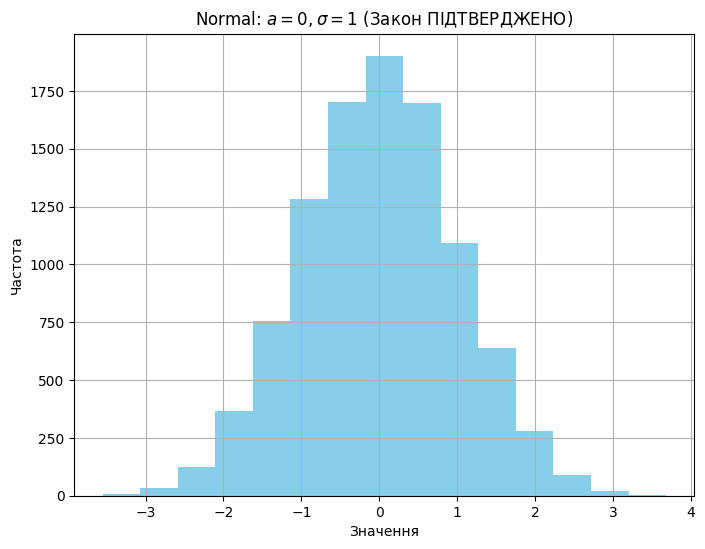

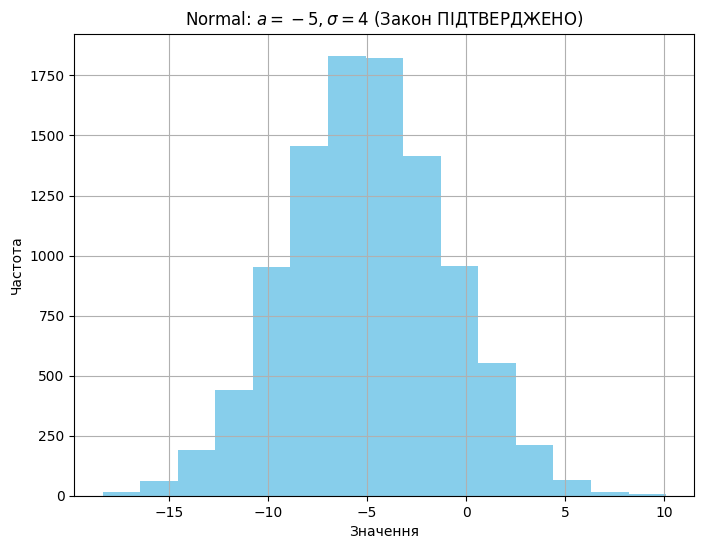

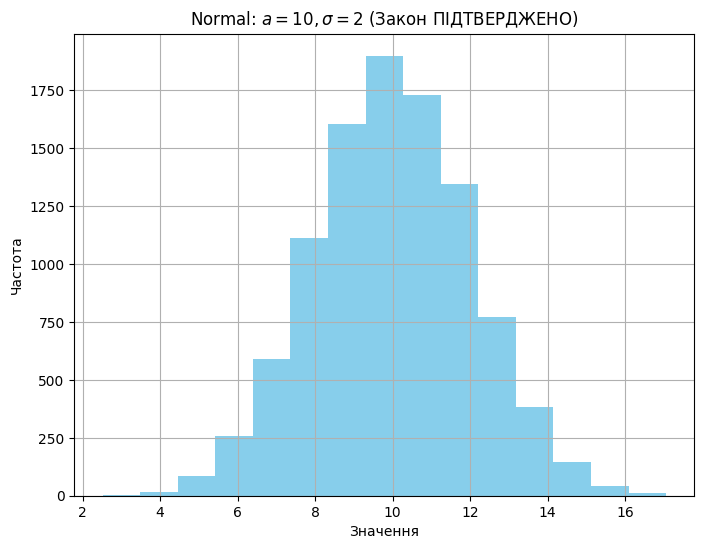

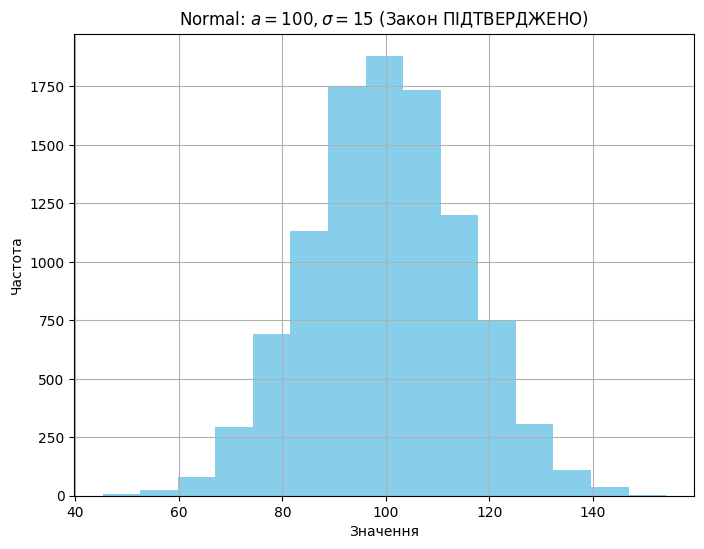

In [1517]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# 1. ФУНКЦІЯ ПЕРЕВІРКИ ДЛЯ НОРМАЛЬНОГО РОЗПОДІЛУ
def test_normal_hypothesis(target_mean, target_std, sample_size):
    print("\n" + "="*60)
    print(f">>> ТЕСТУВАННЯ: a (Mean) = {target_mean}, sigma (Std) = {target_std}")
    print("="*60)

    # --- А. Генерація вибірки (Метод з завдання: сума 12 рівномірних) ---
    # 1. Матриця N x 12
    uniform_matrix = np.random.uniform(size=(sample_size, 12))
    
    # 2. Сума - 6 (наближення до N(0,1))
    standard_normals = uniform_matrix.sum(axis=1) - 6
    
    # 3. Трансформація до N(a, sigma)
    normal_data = target_std * standard_normals + target_mean

    # Розрахунок кількості бінів
    # Якщо немає get_sturges_bin_count, використовуємо формулу Стерджеса вручну:
    # num_bins = int(np.log2(sample_size) + 1)
    num_bins = get_sturges_bin_count(sample_size)

    # --- Б. Отримання гістограми та оцінка параметрів ---
    observed_counts, bin_edges = np.histogram(normal_data, bins=num_bins)
    
    # Оцінюємо параметри з вибірки (для тесту Хі-квадрат це стандарт)
    estimated_mean = np.mean(normal_data)
    estimated_std = np.std(normal_data)
    n_samples = len(normal_data)

    # --- В. Розрахунок теоретичних частот (через CDF) ---
    raw_expected = []
    for i in range(len(bin_edges) - 1):
        left = bin_edges[i]
        right = bin_edges[i+1]
        
        # Площа під кривою Гауса між межами біна
        prob = stats.norm.cdf(right, loc=estimated_mean, scale=estimated_std) - \
               stats.norm.cdf(left, loc=estimated_mean, scale=estimated_std)
        
        raw_expected.append(prob * n_samples)

    # --- Г. Об'єднання малих інтервалів (Критично важливо) ---
    final_obs = []
    final_exp = []
    current_o = 0
    current_e = 0

    for o, e in zip(observed_counts, raw_expected):
        current_o += o
        current_e += e
        # Накопичуємо, поки очікувана частота не стане >= 5
        if current_e >= 5:
            final_obs.append(current_o)
            final_exp.append(current_e)
            current_o = 0
            current_e = 0
            
    # Обробка залишку
    if current_e > 0:
        if len(final_exp) > 0:
            final_obs[-1] += current_o
            final_exp[-1] += current_e
        else:
            final_obs.append(current_o)
            final_exp.append(current_e)

    final_obs = np.array(final_obs)
    final_exp = np.array(final_exp)

    # --- Д. Розрахунок статистики Хі-квадрат ---
    chi2_stat = np.sum((final_obs - final_exp)**2 / final_exp)
    
    # Ступені свободи: k - 1 - m (де m=2 параметри: mean, std)
    df = len(final_obs) - 1 - 2 

    # --- Е. Критичне значення ---
    limit = stats.chi2.ppf(0.95, df)

    # --- Є. Вивід результатів ---
    print(f"Оцінені параметри: Mean={estimated_mean:.4f}, Std={estimated_std:.4f}")
    print(f"Chi2 статистика: {chi2_stat:.4f}")
    print(f"Критичне значення (df={df}): {limit:.4f}")
    
    if chi2_stat < limit:
        result_msg = "Закон ПІДТВЕРДЖЕНО"
        plot_color = 'skyblue'
    else:
        result_msg = "Закон ВІДХИЛЕНО"
        plot_color = 'orange'
    print(f"Результат: {result_msg}")

    # --- Ж. Побудова графіка ---
    plot_title = f'Normal: $a={target_mean}, \sigma={target_std}$ ({result_msg})'
    plot_histogram(
        normal_data, 
        bin_edges, # Оригінальні межі для візуалізації
        title=plot_title, 
        color=plot_color
    )

# ==========================================
# 2. ГОЛОВНИЙ ЦИКЛ (Виконання завдання)
# ==========================================

sample_size_global = 10000

# Список параметрів для перевірки [(mean, std), (mean, std), ...]
# Завдання вимагає "різних значень a і sigma"
params_to_test = [
    (0, 1),    # Стандартний нормальний
    (-5, 4),   # Ваші початкові значення
    (10, 2),   # Зміщене з меншим розкидом
    (100, 15)  # Великі значення
]

for mean_val, std_val in params_to_test:
    test_normal_hypothesis(target_mean=mean_val, target_std=std_val, sample_size=sample_size_global)

# Рівномірний закон розподілу

## Конфігурація графіку гістограми

In [1518]:
sample_size = 10000
num_bins = get_sturges_bin_count(sample_size)
print('Кількість інтервалів для Рівномірного розподілу:', num_bins)

Кількість інтервалів для Рівномірного розподілу: 15


## Формуляція закону розподілу

In [1519]:
multiplier_a = 5**13
modulus_m = 2**31
zi_value = np.random.uniform()

# Початкове значення (Seed / X_0)
# LCG працює з цілими числами, тому перетворюємо початковий float на int
current_x = int(np.random.uniform(1, modulus_m))

uniform_data = np.zeros(sample_size)

for i in range(sample_size):
    current_x = (multiplier_a * current_x) % modulus_m
    uniform_data[i] = current_x / modulus_m

print(uniform_data)


[0.90051551 0.33890404 0.62289738 ... 0.82836621 0.47911372 0.9444131 ]


## Побудова графіку для перевірки закону

<Axes: title={'center': 'Закон - Рівномірний розподіл'}, xlabel='Значення', ylabel='Частота'>

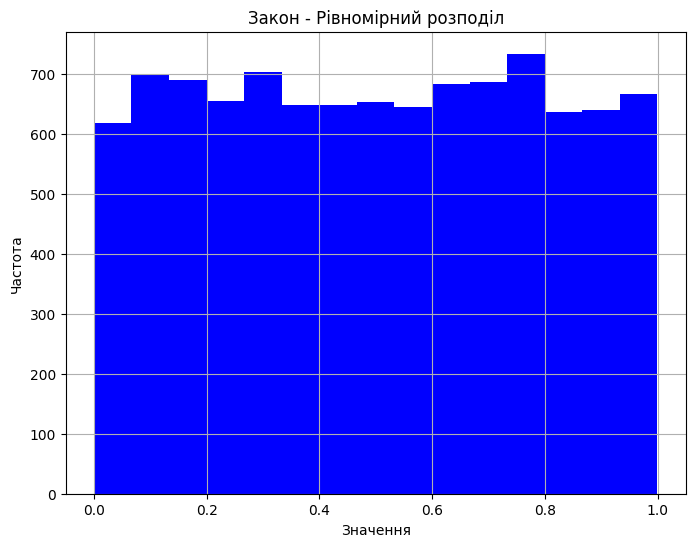

In [1520]:
uniform_counts, uniform_bins = np.histogram(uniform_data, bins=num_bins)
plot_histogram(uniform_data, uniform_bins, title='Закон - Рівномірний розподіл', color='blue')

## Статистика за законом

In [1521]:
uniform_stats = calculate_sample_stats(uniform_data)
uniform_mean, uniform_std = uniform_stats
formatted_chi2 = format_mean_std(uniform_stats, 'Рівномірний розподіл')
print(formatted_chi2)

Рівномірний розподіл: 
Середнє: 0.500, Std: 0.288


## Перевірка за критерієм згоди xi^2

In [1522]:
def prob_uniform(left: float, right: float, lower_bound: float, upper_bound: float) -> float:
    """
    Розраховує ймовірність потрапляння в інтервал.
    PDF = 1 / (upper - lower).
    Ймовірність = Ширина_інтервалу * PDF.
    """
    l = max(left, lower_bound)
    r = min(right, upper_bound)
    
    if l >= r:
        return 0.0

    return (r - l) / (upper_bound - lower_bound)

estimated_lower = uniform_mean - 3 ** 0.5 * uniform_std
estimated_upper = uniform_mean + 3 ** 0.5 * uniform_std
chi2 = calculate_chi2_statistic(sample_size, uniform_counts, uniform_bins,
                            prob_uniform, estimated_lower, estimated_upper)
critical_value = get_chi2_critical_value(0.05, num_bins, 2)
formatted_chi2 = format_chi2_info(chi2, critical_value, 'Рівномірний розподіл')
print(formatted_chi2)

Рівномірний розподіл: 
Chi^2: 18.598, Chi^2 k: 21.02606981748307


In [1523]:
if is_hypothesis_accepted(chi2, critical_value):
    print("Закон рівномірного розподілу працює!")
else:
    print("Закон рівномірного розподілу не працює!")

Закон рівномірного розподілу працює!
